In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import arviz as az
import pymc3 as pm

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

sns.set_context('notebook')
sns.set_style('whitegrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
root = os.getcwd()
print('Working Directory:', root)

Working Directory: C:\Users\2356737\pythonpractice\hierarchical


## Load Data

In [3]:
# Import radon data
srrs2 = pd.read_csv(pm.get_data(os.path.join(root, 'data', 'srrs2.dat')))
srrs2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12777 entries, 0 to 12776
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   idnum      12777 non-null  int64  
 1    state     12777 non-null  object 
 2    state2    12777 non-null  object 
 3    stfips    12777 non-null  int64  
 4    zip       12777 non-null  object 
 5    region    12777 non-null  int64  
 6    typebldg  12777 non-null  int64  
 7    floor     12777 non-null  int64  
 8    room      12777 non-null  int64  
 9    basement  12777 non-null  object 
 10   windoor   12777 non-null  object 
 11   rep       12777 non-null  object 
 12   stratum   12777 non-null  int64  
 13   wave      12777 non-null  object 
 14   starttm   12777 non-null  int64  
 15   stoptm    12777 non-null  int64  
 16   startdt   12777 non-null  int64  
 17   stopdt    12777 non-null  int64  
 18   activity  12777 non-null  float64
 19   pcterr    12777 non-null  float64
 20   adjwt

In [4]:
# Remove empty spaces in the column names
srrs2.columns = srrs2.columns.map(str.strip) # map function can be applied in a numpy array
srrs2['state'].value_counts()

PA    2389
IN    1914
MO    1859
MA    1659
ND    1596
AZ    1507
R5     934
MN     919
Name: state, dtype: int64

In [5]:
# Select observations from MN
srrs_mn = srrs2[srrs2.state=='MN'].copy()
srrs_mn['fips'] = srrs_mn[['stfips', 'cntyfips']].apply(lambda x: str(x[0])+str(x[1]).rjust(3, '0'), axis=1)
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips
5080,5081,MN,MN,27,55735,5,1,1,3,N,...,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001
5081,5082,MN,MN,27,55748,5,1,0,4,Y,...,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001
5082,5083,MN,MN,27,55748,5,1,0,4,Y,...,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001
5083,5084,MN,MN,27,56469,5,1,0,4,Y,...,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001
5084,5085,MN,MN,27,55011,3,1,0,4,Y,...,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003


In [6]:
cty = pd.read_csv(pm.get_data(os.path.join(root, 'data', 'cty.dat')))
cty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3194 entries, 0 to 3193
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   stfips  3194 non-null   int64  
 1   ctfips  3194 non-null   int64  
 2   st      3194 non-null   object 
 3   cty     3194 non-null   object 
 4   lon     3194 non-null   float64
 5   lat     3194 non-null   float64
 6   Uppm    3194 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 174.8+ KB


In [7]:
cty_mn = cty[cty.st=='MN'].copy()
cty_mn['fips'] = cty_mn[['stfips', 'ctfips']].apply(lambda x: str(x[0])+str(x[1]).rjust(3, '0'), axis=1)
cty_mn.head()

,stfips,ctfips,st,cty,lon,lat,Uppm,fips
1326,27,1,MN,AITKIN,-93.415,46.608,0.502054,27001
1327,27,3,MN,ANOKA,-93.246,45.273,0.428565,27003
1328,27,5,MN,BECKER,-95.674,46.935,0.892741,27005
1329,27,7,MN,BELTRAMI,-94.937,47.974,0.552472,27007
1330,27,9,MN,BENTON,-93.998,45.699,0.866849,27009


In [8]:
# Combine home-level info with county-level info
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
n = len(srrs_mn)

srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


In [9]:
# generate county dict
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
print('Number of unique counties:', counties)

county_lookup = dict(zip(mn_counties, range(len(mn_counties))))
list(county_lookup.items())[:5]

Number of unique counties: 85


[('AITKIN', 0), ('ANOKA', 1), ('BECKER', 2), ('BELTRAMI', 3), ('BENTON', 4)]

### Create Local Copies of Variables

In [10]:
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
log_radon = srrs_mn['log_radon'] = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

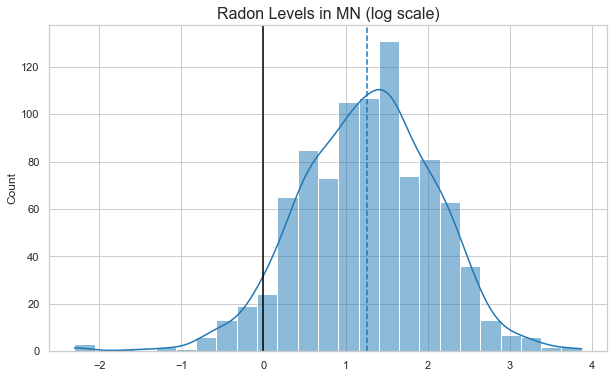

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(log_radon, bins=25, kde=True)
plt.axvline(x=0, ls='-', color='black')
plt.axvline(x=log_radon.mean(), ls='--')
ax.set_title('Radon Levels in MN (log scale)', fontsize=16)
plt.show()

In [12]:
print(floor.size)
# Basement: 0 and 1st Floor: 1
pd.value_counts(floor)

919


0    766
1    153
dtype: int64

## Conventional Approaches

### Complete Pooling

Treat all counties the same and estimate the radon level for each house:

$$
y_i = \alpha +\beta x_i +\varepsilon_i
$$

In [13]:
# Define data
dt_X = np.stack((np.ones(floor.size), floor), axis=1)
dt_X.shape

(919, 2)

In [14]:
# Define coordinates
dt_coords = {"n_obs": np.arange(dt_X.shape[0]), "n_par": np.arange(dt_X.shape[1])}

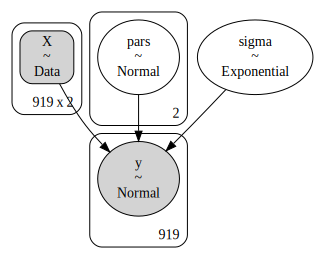

In [15]:
with pm.Model(coords=dt_coords) as pooled_model:
    # Data
    X = pm.Data("X", dt_X, dims=("n_obs", "n_par"))
    
    # Priors
    pars = pm.Normal("pars", 0.0, sigma=1e5, dims="n_par")
    sigma = pm.Exponential("sigma", 1.0)
    
    # Model
    y = pm.math.dot(X, pars)
    
    # Likelihood
    pm.Normal("y", mu=y, sigma=sigma, observed=log_radon, dims="n_obs")

pm.model_to_graphviz(pooled_model)

In [16]:
with pooled_model:
    pooled_trace = pm.sample(2000, n_init=50000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, pars]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


In [17]:
# Display arviz.InferenceData structure
pooled_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [18]:
a, b = pooled_trace['posterior']['pars'][:,1000:,:].mean(dim=('chain', 'draw')).values
print(a, b)

1.3625328483510624 -0.58651358315119


### No Pooling

Model radon independently in county $j$:

$$
y_i = \alpha_j + \beta_j x_i +\varepsilon_i
$$

In [19]:
# Add a dimension in coordinates
dt_coords['County'] = mn_counties

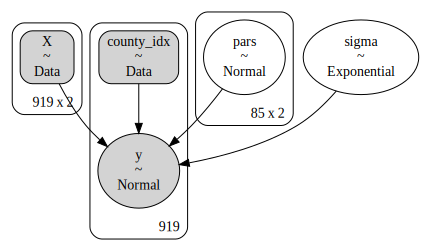

In [20]:
with pm.Model(coords=dt_coords) as unpooled_model:
    # Data
    X = pm.Data("X", dt_X, dims=("n_obs", "n_par"))
    county_idx = pm.Data("county_idx", county, dims="n_obs")
    
    # Priors
    pars = pm.Normal("pars", 0.0, sigma=10, dims=("County", "n_par"))
    sigma = pm.Exponential("sigma", 1.0)
    
    # Model
    pars_ = pars[county_idx]
    y = pm.math.sum(X*pars_, axis=1)
    
    # Likelihood
    pm.Normal("y", mu=y, sigma=sigma, observed=log_radon, dims="n_obs")

pm.model_to_graphviz(unpooled_model)

In [21]:
with unpooled_model:
    unpooled_trace = pm.sample(2000, n_init=50000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, pars]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 94 seconds.


In [22]:
unpooled_means = unpooled_trace.posterior.sel(draw=slice(1000, 2000)).mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_trace)

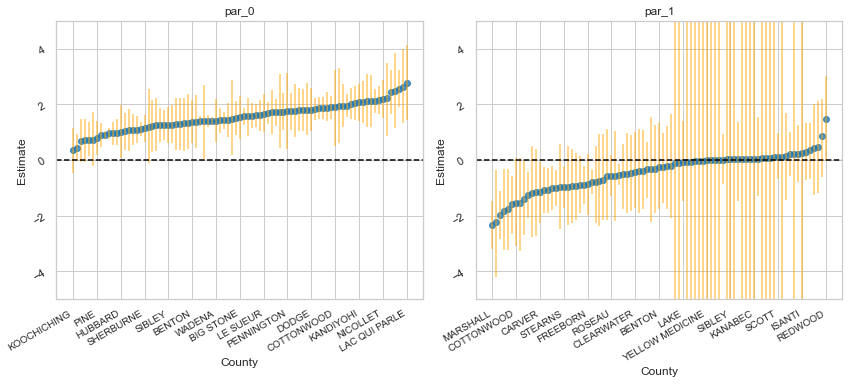

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5))
xticks = np.arange(0, 86, 6)
fontdict = {"horizontalalignment": "right", "fontsize": 10}
for ax, par_i in zip(axes, [0, 1]):
    unpooled_means_iter = unpooled_means.sel(n_par=par_i).sortby('pars')
    unpooled_hdi_iter = unpooled_hdi.sel(n_par=par_i).sortby(unpooled_means_iter.pars)
    unpooled_means_iter.plot.scatter(x="County", y="pars", ax=ax, alpha=0.8)
    ax.vlines(
        np.arange(mn_counties.size),
        unpooled_hdi_iter.pars.sel(hdi="lower"),
        unpooled_hdi_iter.pars.sel(hdi="higher"),
        color="orange", alpha=0.6
    )
    ax.axhline(y=0, ls='--', color='black')
    ax.set(title=f"par_{par_i}", ylabel="Estimate", ylim=(-5, 5))
    ax.set_xticks(xticks)
    ax.set_xticklabels(unpooled_means_iter.County.values[xticks], fontdict=fontdict)
    ax.tick_params(rotation=30)
fig.tight_layout()

### Comparisons

In [24]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 'CLAY',
                   'STEARNS', 'RAMSEY', 'DAKOTA', 'ST LOUIS')
srrs_mn['county'].value_counts()[list(sample_counties)]

LAC QUI PARLE      2
AITKIN             4
KOOCHICHING        7
CLAY              14
STEARNS           25
RAMSEY            32
DAKOTA            63
ST LOUIS         116
Name: county, dtype: int64

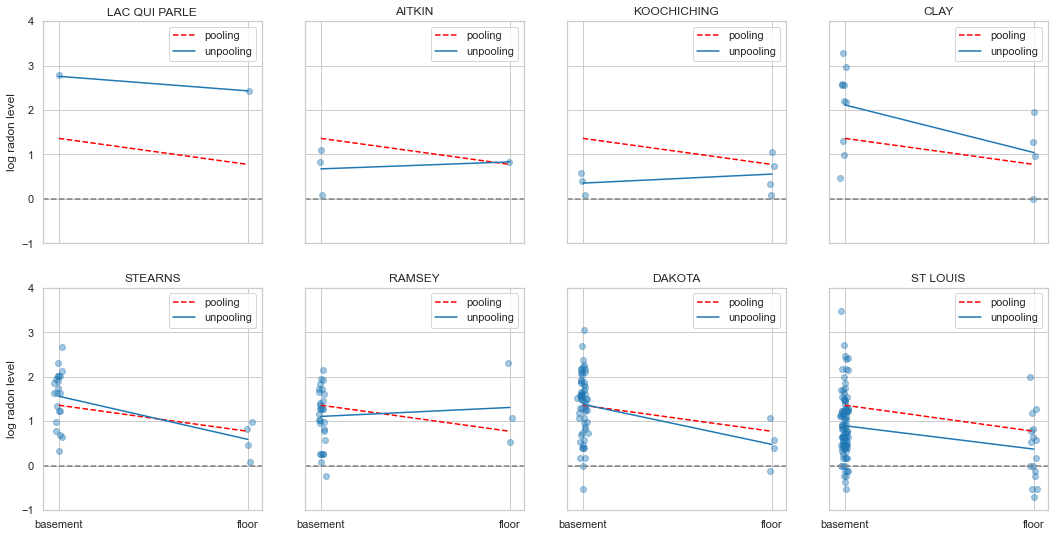

In [25]:
fig, axes = plt.subplots(2, 4, figsize=(18, 9), sharey=True, sharex=True)
axes = axes.ravel()

xvals = np.linspace(0, 1)

for i, c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    a_, b_ = unpooled_means.sel(County=c).pars.values
    
    # Plot both models and data    
    axes[i].plot(xvals, a  + b * xvals, 'r--', label='pooling')
    axes[i].plot(xvals, a_ + b_* xvals, label='unpooling')
    axes[i].axhline(y=0, ls='--', color='gray')
    
    # Set labels
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 4)
    axes[i].set_title(c, fontsize=12)
    axes[i].legend()
    if not i%4:
        axes[i].set_ylabel('log radon level')

**Neither of these models are satisfactory:**

+ if we are trying to identify high-radon counties, pooling is useless
+ we do not trust extreme unpooled estimates produced by models using few observations

## Multilevel and Hierarchical Models

+ When we **pool** our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance)
+ When we analyze data **unpooled**, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are to large to combine them
+ In a **hierarchical** model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is **parital pooling**

### Partial Pooling

A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average of the unpooled county estimates (county estimates are from their own distributions) and the pooled estimates (county estimates are from the same population distribution).

$$
E(\alpha|Y_j) = \frac{(n_j/\sigma_y^2)\bar y_j + (1/\sigma_\alpha^2)\bar y}{(n_j/\sigma_y^2) + (1/\sigma_\alpha^2)} =
\frac{(\sigma_\alpha^2)\bar y_j + (\sigma_y^2/n_j)\bar y}{(\sigma_y^2/n_j) + (\sigma_\alpha^2)}
$$

where $n_j$, $\bar y_j$, and $\sigma_y^2$ are the sample size, mean, and variance of group $j$, and $\bar y$ and $\sigma_\alpha^2$ are the overall/population mean and variance. Note this is a Normal-Normal model where the prior mean is from a Normal distribution (i.e., $\alpha \sim N(\mu, \tau_\alpha^2)$, county estimates are from the same distribution) and the data are also from a Normal distribution (i.e., $Y_j \sim N(\alpha, \tau_y^2)$, county estimates are from their own distributions). In practice, $\mu=\bar y$, $\tau_\alpha^2=\sigma_\alpha^2$, $\alpha$ for group $j$ is $\bar y_j$ and $\tau_y^2=\sigma_y^2$. As a result, $\alpha | Y_j$ is given by the formula above.

+ Estimates for counties with smaller sample sizes will shrink towards the state-wide average.
+ Estimates for counties with larger sample sizes will be closer to the unpooled county estimates.

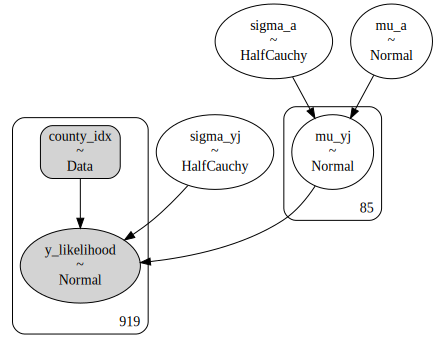

In [26]:
with pm.Model(coords=dt_coords) as partial_pooling:
    # Data
    county_idx = pm.Data("county_idx", county, dims="n_obs")
    
    # Hyper priors
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 1)
    
    # Priors
    mu_yj = pm.Normal('mu_yj', mu=mu_a, sd=sigma_a, dims="County")
    sigma_yj = pm.HalfCauchy('sigma_yj', 1)
    
    # Expected value (Intercept in a regression with a constant term ONLY)
    y = mu_yj[county_idx]
    
    # Data likelihood
    pm.Normal('y_likelihood', mu=y, sd=sigma_yj, observed=log_radon)
    
pm.model_to_graphviz(partial_pooling)

In [27]:
with partial_pooling:
    partial_pooling_trace = pm.sample(2000, n_init=50000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_yj, mu_yj, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 79 seconds.
The number of effective samples is smaller than 25% for some parameters.


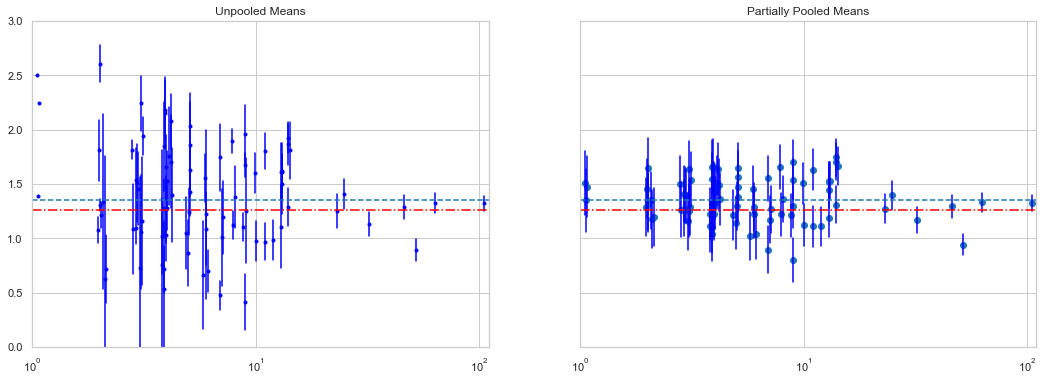

In [28]:
sample_trace = partial_pooling_trace['mu_yj', 1000:]

fig, axes = plt.subplots(1, 2, figsize=(18,6), sharex=True, sharey=True)
samples, counties = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=counties)

# Plot unpooled means
n_county = srrs_mn.groupby('county')['idnum'].count()
unpooled_simple_means = srrs_mn.groupby('county')['log_radon'].mean()
unpooled_simple_sd = srrs_mn.groupby('county')['log_radon'].std()
unpooled = pd.DataFrame({'n':n_county, 'm':unpooled_simple_means, 'sd':unpooled_simple_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].axhline(sample_trace.mean(), ls='--')
axes[0].axhline(log_radon.mean(), ls='-.', color='red')
axes[0].set_xscale('log')
axes[0].set_title('Unpooled Means', fontsize=12)


# Plot partially pooled means
simple_means = sample_trace.mean(axis=0)
simple_sd = sample_trace.std(axis=0)
axes[1].scatter(n_county.values + jitter, simple_means)
for j,n,m,s in zip(jitter, n_county.values, simple_means, simple_sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-')
axes[1].axhline(sample_trace.mean(), ls='--')
axes[1].axhline(log_radon.mean(), ls='-.', color='red')
axes[1].set_xscale('log')
axes[1].set_xlim(1, 110)
axes[1].set_ylim(0, 3)
axes[1].set_title('Partially Pooled Means', fontsize=12)

plt.show()

**Note**: The difference between the unpooled and partially-pooled estimates is more apparent at smaller sample sizes. The former are both more extreme and more imprecise (i.e., large se).

### Varying Intercept and Slope Model

General model allows both the intercept and slop to vary by county:
$$
y_i = \alpha_{j}+\beta_{j} x_i +\varepsilon_i
$$

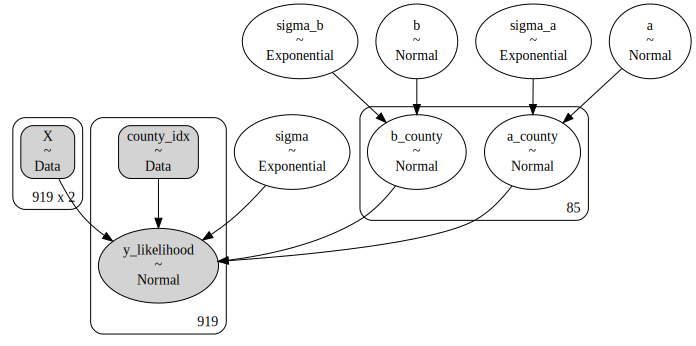

In [29]:
with pm.Model(coords=dt_coords) as varying_intercept_slope:
    # Data
    X = pm.Data("X", dt_X, dims=("n_obs", "n_par"))
    county_idx = pm.Data("county_idx", county, dims="n_obs")
    
    # Hyper priors
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5)
    
    # Priors 
    ## Varying intercepts
    a_county = pm.Normal("a_county", mu=a, sigma=sigma_a, dims="County")
    ## Varying slopes
    b_county = pm.Normal("b_county", mu=b, sigma=sigma_b, dims="County")
    ## Error
    sigma = pm.Exponential("sigma", 1.0)
    
    # Model
    pars = pm.math.stack((a_county[county_idx], b_county[county_idx]), axis=1)
    y = pm.math.sum(X*pars, axis=1)
    
    # Likelihood
    pm.Normal("y_likelihood", mu=y, sigma=sigma, observed=log_radon, dims="n_obs")
    
pm.model_to_graphviz(varying_intercept_slope)

In [30]:
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000, tune=2000, target_accept=0.99, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_county, a_county, sigma_b, b, sigma_a, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 180 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9366458960754177, but should be close to 0.99. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9699594185568178, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


**Note: There are 14 parameters chains *NOT* converging in this process.**

An alternative solution is to reparametrize our model using the "[non-centered parametrization](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/)".

#### Reparameterization

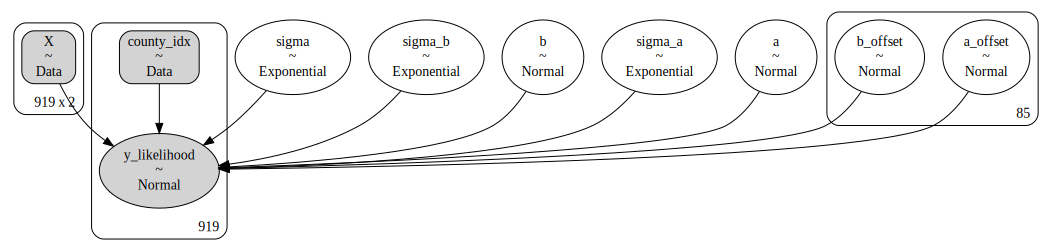

In [31]:
with pm.Model(coords=dt_coords) as varying_intercept_slope:
    # Data
    X = pm.Data("X", dt_X, dims=("n_obs", "n_par"))
    county_idx = pm.Data("county_idx", county, dims="n_obs")
    
    # Hyper priors
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5)
    
    # Reparameterization 
    ## Varying intercepts
    a_offset = pm.Normal("a_offset", mu=0, sigma=1, dims="County")
    a_county = a + a_offset[county_idx]*sigma_a
    ## Varying slopes
    b_offset = pm.Normal("b_offset", mu=0, sigma=1, dims="County")
    b_county = b + b_offset[county_idx]*sigma_b
    ## Error
    sigma = pm.Exponential("sigma", 1.0)
    
    # Model
    pars = pm.math.stack((a_county, b_county), axis=1)
    y = pm.math.sum(X*pars, axis=1)
    
    # Likelihood
    pm.Normal("y_likelihood", mu=y, sigma=sigma, observed=log_radon, dims="n_obs")
    
pm.model_to_graphviz(varying_intercept_slope)

In [32]:
with varying_intercept_slope:
    varying_intercept_slope_rep_idata = pm.sample(2000, tune=2000, target_accept=0.99, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_offset, a_offset, sigma_b, b, sigma_a, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 202 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [33]:
result = az.summary(varying_intercept_slope_idata)
result['r_hat'].value_counts()

1.00    92
1.01    67
1.02    15
1.06     1
Name: r_hat, dtype: int64

In [34]:
result_rep = az.summary(varying_intercept_slope_rep_idata)
result_rep['r_hat'].value_counts()

1.0    175
Name: r_hat, dtype: int64

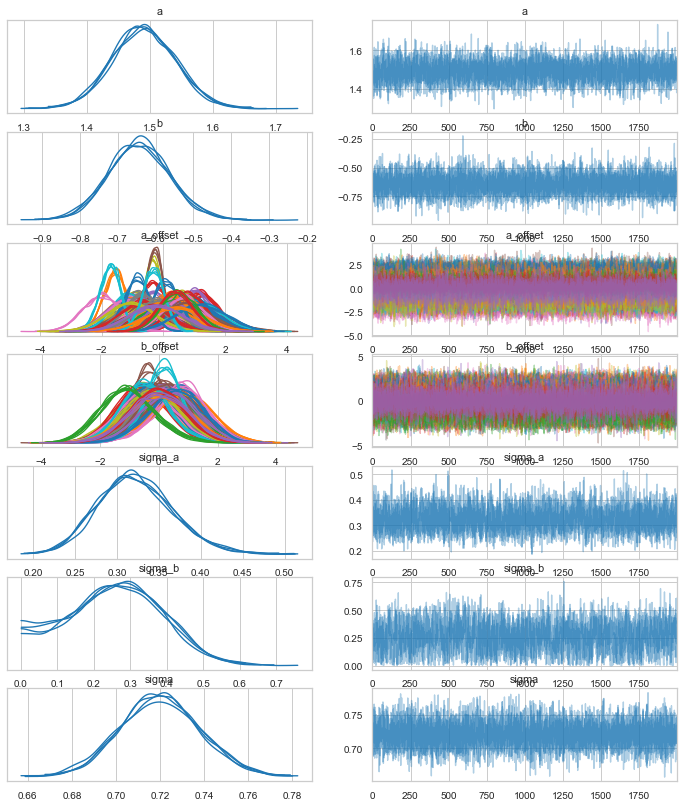

In [35]:
az.plot_trace(varying_intercept_slope_rep_idata, compact=True, chain_prop={"ls": "-"})
plt.show()

+ $\sigma_\alpha$ is not that big, implying that counties do differ in their baseline radon levels, but not by a lot.
+ $\sigma_\beta$ however is very close to zero, suggesting that counties don't vary that much in their answer to the floor "treatment". 
+ Compared to $\sigma_\alpha$, the number of **effective samples is quite low for $\sigma_\beta$**. The *small sigma_b near zero* probably caused the divergence when using the *centered parametrization* in MCMC.

In [36]:
result.loc[['sigma_a', 'sigma_b']]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_a,0.322,0.045,0.238,0.404,0.001,0.001,2284.0,4031.0,1.00
sigma_b,0.257,0.129,0.024,0.457,0.016,0.011,59.0,43.0,1.06


In [37]:
result_rep.loc[['sigma_a', 'sigma_b']]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_a,0.323,0.045,0.24,0.409,0.001,0.001,3261.0,5103.0,1.0
sigma_b,0.257,0.128,0.00,0.451,0.003,0.002,1444.0,2475.0,1.0


#### Comparisons

In [38]:
partialpooling_means = varying_intercept_slope_idata.posterior.sel(draw=slice(1000, 2000)).mean(dim=("chain", "draw"))
partialpooling_rep_means = varying_intercept_slope_rep_idata.posterior.sel(draw=slice(1000, 2000)).mean(dim=("chain", "draw"))

In [39]:
partialpooling_means

<xarray.Dataset>
Dimensions:   (County: 85)
Coordinates:
  * County    (County) object 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
Data variables:
    a         float64 1.489
    b         float64 -0.6415
    a_county  (County) float64 1.214 0.9881 1.492 1.54 ... 1.655 1.617 1.415
    b_county  (County) float64 -0.6147 -0.7798 -0.632 ... -0.6574 -0.6381
    sigma_a   float64 0.3225
    sigma_b   float64 0.2573
    sigma     float64 0.7203

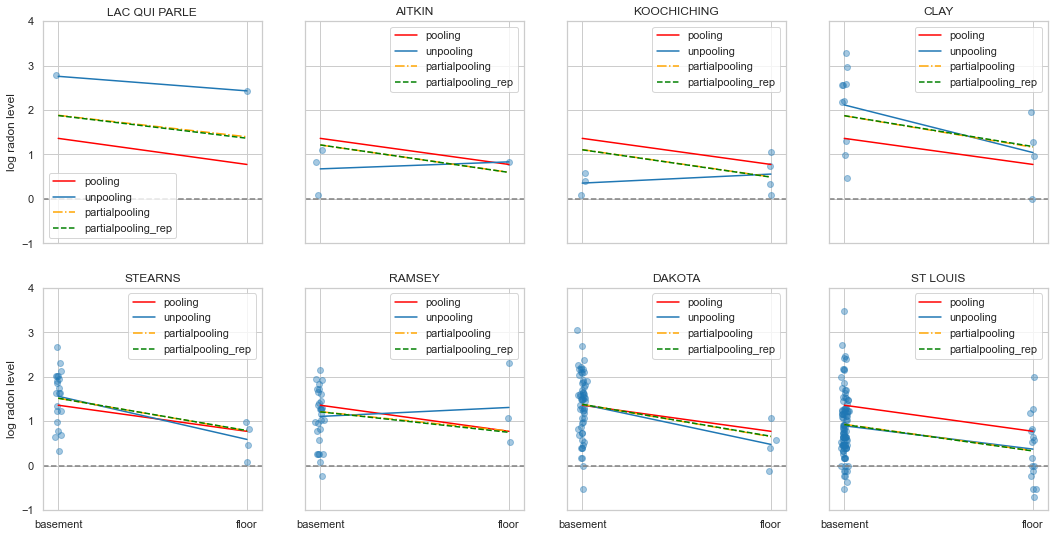

In [40]:
fig, axes = plt.subplots(2, 4, figsize=(18, 9), sharey=True, sharex=True)
axes = axes.ravel()

xvals = np.linspace(0, 1)
a, b = pooled_trace['posterior']['pars'][:,1000:,:].mean(dim=('chain', 'draw')).values

for i, c in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    a_, b_ = unpooled_means.sel(County=c).pars.values
    
    # Partial pooling model
    a_j = partialpooling_means.sel(County=c)['a_county'].values
    b_j = partialpooling_means.sel(County=c)['b_county'].values
    
    # Partial pooling model (reparameterization)
    a_rep = partialpooling_rep_means.sel(County=c)['a'].values + \
    partialpooling_rep_means.sel(County=c)['a_offset'].values * partialpooling_rep_means.sel(County=c)['sigma_a'].values
    b_rep = partialpooling_rep_means.sel(County=c)['b'].values + \
    partialpooling_rep_means.sel(County=c)['b_offset'].values * partialpooling_rep_means.sel(County=c)['sigma_b'].values
    
    # Plot both models and data    
    axes[i].plot(xvals, a  + b * xvals, 'red', label='pooling')
    axes[i].plot(xvals, a_ + b_* xvals, label='unpooling')
    axes[i].plot(xvals, a_j + b_j * xvals, 'orange', linestyle='dashdot', label='partialpooling')
    axes[i].plot(xvals, a_rep + b_rep * xvals, 'green', linestyle='dashed', label='partialpooling_rep')
    axes[i].axhline(y=0, ls='--', color='gray')
    
    # Set labels
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 4)
    axes[i].set_title(c, fontsize=12)
    axes[i].legend()
    if not i%4:
        axes[i].set_ylabel('log radon level')

### Correlated Parameters

We can take into account the **covariation between intercepts and slopes**: For example, when baseline radon is low in a given county, maybe that means the difference between floor and basement measurements will decrease – because there isn't that much radon anyway. 

$$
y_i = \alpha_{j}+\beta_{j} x_i +\varepsilon_i
$$

$$
\left[\begin{array}~\alpha_j \\ \beta_j \end{array}\right] \sim MvNormal
\left(\left[\begin{array}~\alpha \\ \beta\end{array}\right], \Sigma\right), 
$$

where $\Sigma=\left(\begin{array}~\sigma_\alpha & 0 \\ 0 & \sigma_\beta \end{array}\right)P\left(\begin{array}~\sigma_\alpha & 0 \\ 0 & \sigma_\beta \end{array}\right)$
and $P$ is the correlation matrix.

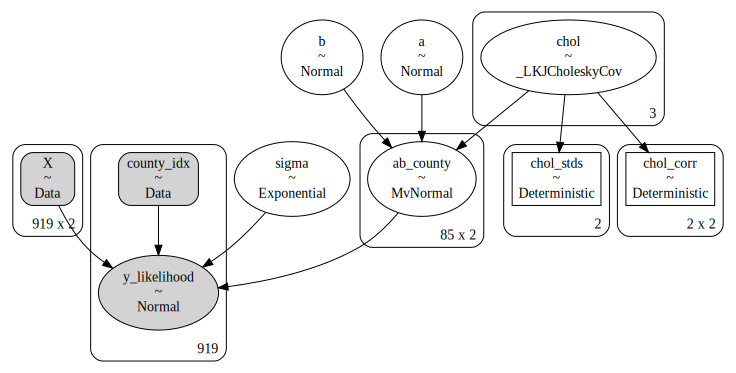

In [41]:
with pm.Model(coords=dt_coords) as covariation_intercept_slope:
    # Data
    X = pm.Data("X", dt_X, dims=("n_obs", "n_par"))
    county_idx = pm.Data("county_idx", county, dims="n_obs")
    
    # Hyper priors
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    ## Distribution (used in LKJCholeskyCov not the random variables)
    sd_dist = pm.Exponential.dist(0.5, shape=2)
    ## Cholesky matrix, correlation, std
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist, compute_corr=True)
    
    # Prior
    ab_county = pm.MvNormal("ab_county", mu=pm.math.stack((a, b), axis=0), chol=chol, dims=("County", "n_par"))
    sigma = pm.Exponential("sigma", 1.0)
    
    # Model
    pars = ab_county[county_idx]
    y = pm.math.sum(X*pars, axis=1)
    
    # Likelihood
    pm.Normal("y_likelihood", mu=y, sigma=sigma, observed=log_radon, dims="n_obs")
    
pm.model_to_graphviz(covariation_intercept_slope)

**NOTE**: The centered version represents the mathematical notions but it could probably raise the problem of divergence. As a result, we need specify the non-centered version as well.

#### Reparameterization

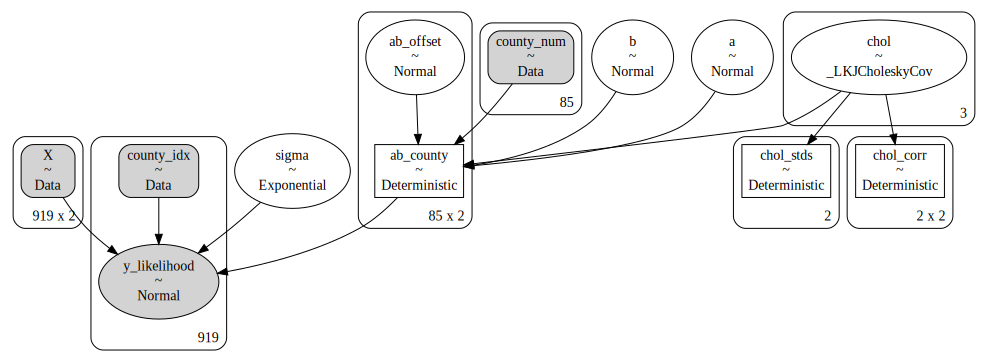

In [97]:
dt_coords["param"] = ["a", "b"]
dt_coords["param_bis"] = ["a", "b"]

with pm.Model(coords=dt_coords) as covariation_intercept_slope:
    # Data
    X = pm.Data("X", dt_X, dims=("n_obs", "n_par"))
    county_idx = pm.Data("county_idx", county, dims="n_obs")
    county_num = pm.Data("county_num", np.arange(counties), dims="County")
    
    # Hyper priors
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    ## Distribution (used in LKJCholeskyCov not the random variables)
    sd_dist = pm.Exponential.dist(0.5, shape=2)
    ## Cholesky matrix, correlation, std
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist, compute_corr=True)
    
    # Reparameterization 
    ab_offset = pm.Normal("ab_offset", mu=0.0, sigma=1.0, dims=("County", "n_par"))
    ab_county = pm.Deterministic("ab_county", pm.math.stack((a*pm.math.ones_like(county_num), b*pm.math.ones_like(county_num)), axis=1) +\
                                 pm.math.dot(ab_offset, chol), dims=("County", "n_par"))    
    sigma = pm.Exponential("sigma", 1.0)
    
    # Model
    y = pm.math.sum(X*ab_county[county_idx], axis=1)
    
    # Likelihood
    pm.Normal("y_likelihood", mu=y, sigma=sigma, observed=log_radon, dims="n_obs")
    
pm.model_to_graphviz(covariation_intercept_slope)

In [98]:
with covariation_intercept_slope:
    covariation_intercept_slope_idata = pm.sample(2000, tune=2000, target_accept=0.99, return_inferencedata=True, 
                                                  idata_kwargs={"dims": {"chol_stds": ["param"], "chol_corr": ["param", "param_bis"]}})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ab_offset, chol, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 286 seconds.
The number of effective samples is smaller than 10% for some parameters.


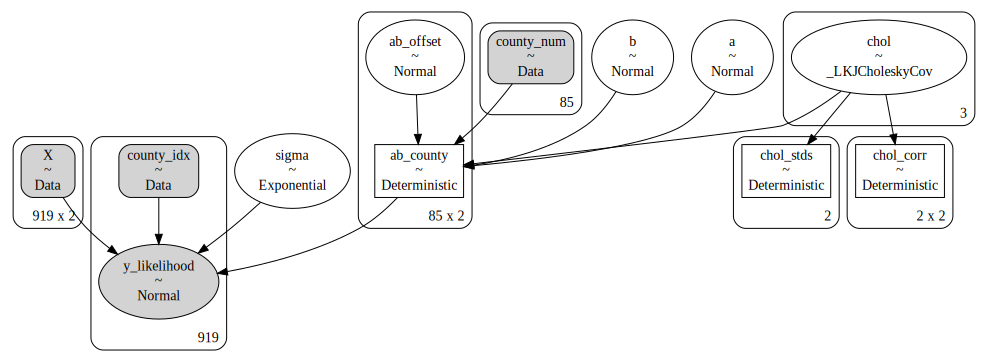

In [92]:
dt_coords["param"] = ["a", "b"]
dt_coords["param_bis"] = ["a", "b"]

with pm.Model(coords=dt_coords) as covariation_intercept_slope_alt:
    # Data
    X = pm.Data("X", dt_X, dims=("n_obs", "n_par"))
    county_idx = pm.Data("county_idx", county, dims="n_obs")
    county_num = pm.Data("county_num", np.arange(counties), dims="County")
    
    # Hyper priors
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    ## Distribution (used in LKJCholeskyCov not the random variables)
    sd_dist = pm.Exponential.dist(0.5, shape=2)
    ## Cholesky matrix, correlation, std
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist, compute_corr=True)
    
    # Reparameterization 
    ab_offset = pm.Normal("ab_offset", mu=0.0, sigma=1.0, dims=("County", "n_par"))
    ab_county = pm.Deterministic("ab_county", pm.math.stack(([a], [b]), axis=1)[pm.math.zeros_like(county_num)] +\
                                 pm.math.dot(ab_offset, chol), dims=("County", "n_par"))
    sigma = pm.Exponential("sigma", 1.0)
    
    # Model
    y = pm.math.sum(X*ab_county[county_idx], axis=1)
    
    # Likelihood
    pm.Normal("y_likelihood", mu=y, sigma=sigma, observed=log_radon, dims="n_obs")
    
pm.model_to_graphviz(covariation_intercept_slope_alt)

In [93]:
with covariation_intercept_slope_alt:
    covariation_intercept_slope_alt_idata = pm.sample(2000, tune=2000, target_accept=0.99, return_inferencedata=True, 
                                                      idata_kwargs={"dims": {"chol_stds": ["param"], "chol_corr": ["param", "param_bis"]}})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ab_offset, chol, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 296 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [99]:
covariation_intercept_slope_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [103]:
az.summary(covariation_intercept_slope_idata, var_names=["~ab_offset", "~ab_county"])

C:\Users\2356737\.conda\envs\MMM\lib\site-packages\arviz\stats\diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.492,0.052,1.395,1.588,0.001,0.001,3702.0,5027.0,1.00
b,-0.651,0.081,-0.808,-0.503,0.001,0.001,6379.0,5494.0,1.00
chol[0],0.313,0.050,0.222,0.405,0.001,0.001,1786.0,1935.0,1.00
chol[1],-0.061,0.098,-0.256,0.111,0.004,0.003,718.0,1264.0,1.01
chol[2],0.247,0.134,0.004,0.459,0.004,0.003,1289.0,1631.0,1.00
chol_stds[a],0.313,0.050,0.222,0.405,0.001,0.001,1786.0,1935.0,1.00
chol_stds[b],0.270,0.139,0.005,0.487,0.004,0.003,1167.0,1516.0,1.00
"chol_corr[a, a]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"chol_corr[a, b]",-0.173,0.364,-0.803,0.581,0.012,0.009,873.0,1603.0,1.01
"chol_corr[b, a]",-0.173,0.364,-0.803,0.581,0.012,0.009,873.0,1603.0,1.01


The correlation between slopes and intercepts (i.e., `chol_corr[a,b]`) seems to be negative: when a_county increases, b_county tends to decrease (be more negative).

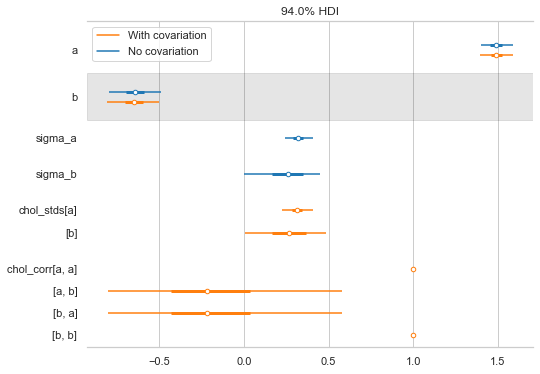

In [108]:
az.plot_forest(
    [varying_intercept_slope_rep_idata, covariation_intercept_slope_idata],
    model_names=["No covariation", "With covariation"],
    var_names=["a", "b", "sigma_a", "sigma_b", "chol_stds", "chol_corr"],
    combined=True,
    figsize=(8, 6)
);

The estimates are very close to each other, both for the means and the standard deviations. However, the information in Rho is only seen at the county level: It gets an even more informed pooling of information for all county parameters.

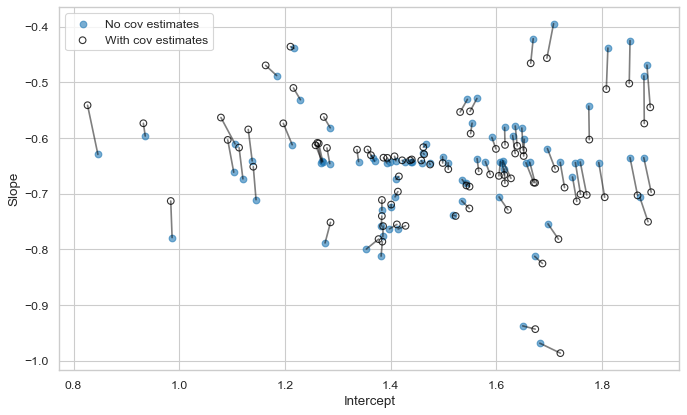

In [114]:
post = varying_intercept_slope_rep_idata.posterior
avg_a_county = (post.a + post.a_offset * post.sigma_a).mean(dim=("chain", "draw"))
avg_b_county = (post.b + post.b_offset * post.sigma_b).mean(dim=("chain", "draw"))

a_county_cov = covariation_intercept_slope_idata.posterior["ab_county"].sel(n_par=0).mean(dim=("chain", "draw"))
b_county_cov = covariation_intercept_slope_idata.posterior["ab_county"].sel(n_par=1).mean(dim=("chain", "draw"))

# plot both and connect with lines
plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(avg_a_county, avg_b_county, label="No cov estimates", alpha=0.6)
plt.scatter(
    a_county_cov,
    b_county_cov,
    facecolors="none",
    edgecolors="k",
    lw=1,
    label="With cov estimates",
    alpha=0.8
)
plt.plot([avg_a_county, a_county_cov], [avg_b_county, b_county_cov], "k-", alpha=0.5)
plt.xlabel("Intercept")
plt.ylabel("Slope")
plt.legend();

**NOTE**: The negative correlation is somewhat clear here: When the intercept increases, the slope decreases. So we understand why the model put most of the posterior weight into negative territory for Rho. Nevertheless, the negativity isn't that obvious, which is why the model gives a non-trivial posterior probability to the possibility that Rho could in fact be zero or positive.

+ Modeling the correlation didn't change inference that much: The posterior distributions of the average effects (a and b) and standard deviations are almost identical.
+ On average the model with covariation will be more accurate, because it squeezes additional information from the data to shrink estimates in both dimensions.

### Adding Group-level Predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. Instead of describing variation in the expected radon value using simple random effects, we specify another regression model with a county-level covariate. For example, consider the varying-intercepts model:

$$
\begin{array}~
y_i &=& \alpha_j +\beta x_i +\varepsilon_i, \text{ where}\\
\alpha_j &=& \gamma_0 +\gamma_1 u_j+\zeta_j \text{ and }\\
\zeta_j &\sim& N(0,\sigma^2_\alpha)
\end{array}
$$

Note that the model has both an indicator variable for each county and a county-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial
pooling of the intercepts towards the expected value of the group-level linear model avoids this.

+ Group-level predictors also serve to reduce group-level variation, $\sigma_\alpha$
+ The group-level estimate induces stronger pooling – by definition, **a smaller $\sigma_\alpha$ means a stronger shrinkage of counties parameters towards the overall state mean**

count    85.000000
mean      1.082369
std       0.354871
min       0.414025
25%       0.849343
50%       1.161930
75%       1.324650
max       1.695580
Name: Uppm, dtype: float64


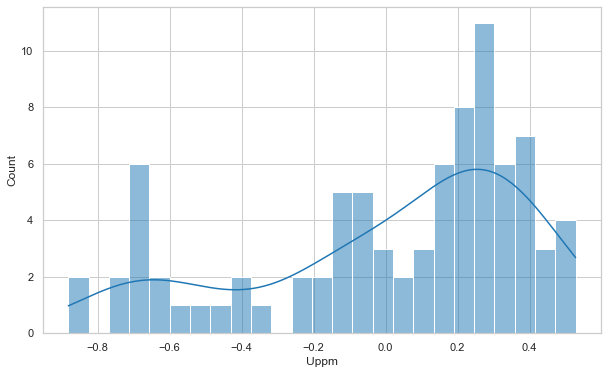

In [148]:
# Load Uranium Data
srrs_mn['county_id'] = srrs_mn['county'].map(county_lookup)
dt_Uran = srrs_mn[['county_id', 'county', 'Uppm']].drop_duplicates().sort_values(by='county_id')
uran = np.log(dt_Uran.Uppm)

# Sample Statistics
print(dt_Uran.Uppm.describe())

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(uran, bins=25, kde=True)
# sns.scatterplot(x=dt_Uran.county, y=dt_Uran.Uppm)
# plt.tick_params(rotation=90)
plt.show()

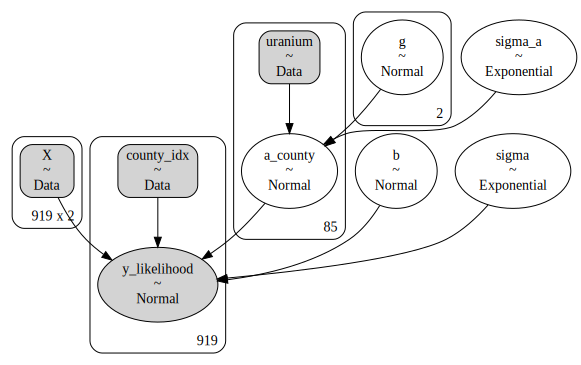

In [149]:
with pm.Model(coords=dt_coords) as hierarchical_intercept:
    # Data
    X = pm.Data("X", dt_X, dims=("n_obs", "n_par"))
    county_idx = pm.Data("county_idx", county, dims="n_obs")
    uranium = pm.Data("uranium", uran, dims="County")
    
    # Hyper priors
    g = pm.Normal("g", mu=0.0, sigma=10.0, shape=2)
    sigma_a = pm.Exponential("sigma_a", 1.0)
        
    # Priors
    a = g[0] + g[1] * uranium
    a_county = pm.Normal("a_county", mu=a, sigma=sigma_a, dims="County")
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma = pm.Exponential("sigma", 1.0)
    
    # Model
    pars = pm.math.stack((a_county[county_idx], b*pm.math.ones_like(county_idx)), axis=1)
    y = pm.math.sum(X*pars, axis=1)
    
    pm.Normal("y_likelihood", mu=y, sigma=sigma, observed=log_radon, dims="n_obs")

pm.model_to_graphviz(hierarchical_intercept)

#### Reparameterization

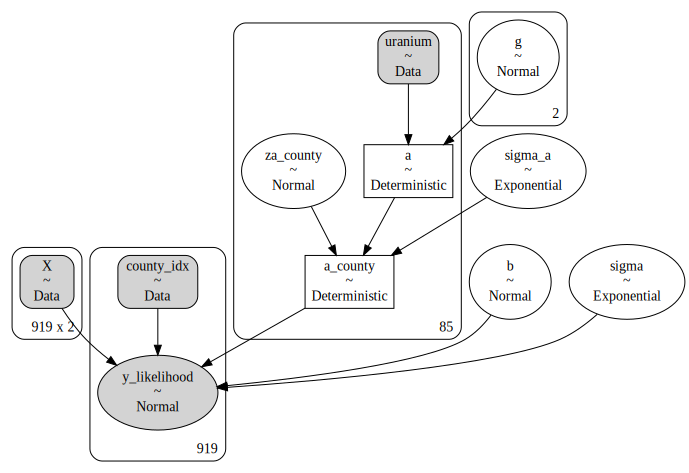

In [152]:
with pm.Model(coords=dt_coords) as hierarchical_intercept:
    # Data
    X = pm.Data("X", dt_X, dims=("n_obs", "n_par"))
    county_idx = pm.Data("county_idx", county, dims="n_obs")
    uranium = pm.Data("uranium", uran, dims="County")
    
    # Hyper priors
    g = pm.Normal("g", mu=0.0, sigma=10.0, shape=2)
    sigma_a = pm.Exponential("sigma_a", 1.0)
        
    # Priors
    a = pm.Deterministic("a", g[0] + g[1] * uranium, dims="County") 
    za_county = pm.Normal("za_county", mu=0.0, sigma=1.0, dims="County")
    a_county = pm.Deterministic("a_county", a + za_county * sigma_a, dims="County")
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma = pm.Exponential("sigma", 1.0)
    
    # Model
    pars = pm.math.stack((a_county[county_idx], b*pm.math.ones_like(county_idx)), axis=1)
    y = pm.math.sum(X*pars, axis=1)
    
    pm.Normal("y_likelihood", mu=y, sigma=sigma, observed=log_radon, dims="n_obs")

pm.model_to_graphviz(hierarchical_intercept)

In [153]:
with hierarchical_intercept:
    hierarchical_intercept_idata = pm.sample(2000, tune=2000, target_accept=0.99, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, za_county, sigma_a, g]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 141 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [154]:
hierarchical_intercept_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [162]:
dt_uranium = hierarchical_intercept_idata.constant_data.uranium
# assign_coords will return a new object with the new coordinates in addition to the existing data
post = hierarchical_intercept_idata.posterior.assign_coords(uranium=dt_uranium)
avg_a = post["a"].mean(dim=("chain", "draw")).sortby("uranium")
avg_a_county = post["a_county"].mean(dim=("chain", "draw"))
avg_a_county_hdi = az.hdi(post, var_names="a_county")["a_county"]

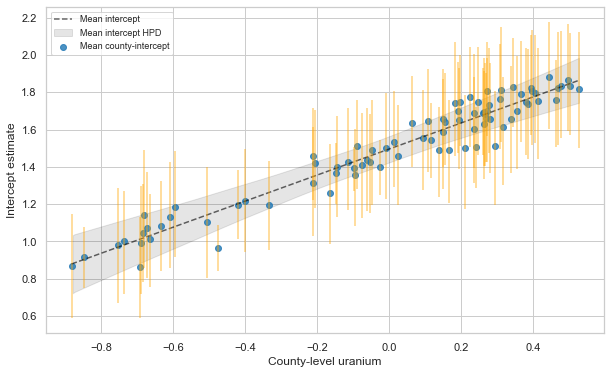

In [173]:
_, ax = plt.subplots(figsize=(10,6))
ax.plot(avg_a.uranium, avg_a, "k--", alpha=0.6, label="Mean intercept")
az.plot_hdi(
    dt_uranium,
    post["a"],
    fill_kwargs={"alpha": 0.1, "color": "k", "label": "Mean intercept HPD"},
    ax=ax,
)
ax.scatter(dt_uranium, avg_a_county, alpha=0.8, label="Mean county-intercept")
ax.vlines(
    dt_uranium,
    avg_a_county_hdi.sel(hdi="lower"),
    avg_a_county_hdi.sel(hdi="higher"),
    alpha=0.5,
    color="orange"
)
plt.xlabel("County-level uranium")
plt.ylabel("Intercept estimate")
plt.legend(fontsize=9, loc='upper left');

In [175]:
with pm.Model(coords=dt_coords) as varying_intercept:
    # Data
    X = pm.Data("X", dt_X, dims=("n_obs", "n_par"))
    county_idx = pm.Data("county_idx", county, dims="n_obs")
    
    # Hyper priors
    a = pm.Normal("a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    
    # Priors
    a_county = pm.Normal("a_county", mu=a, sigma=sigma_a, dims="County")
    b = pm.Normal("b", mu=0.0, sigma=10.0)
    sigma = pm.Exponential("sigma", 1.0)
    
    # Model
    pars = pm.math.stack((a_county[county_idx], b*pm.math.ones_like(county_idx)), axis=1)
    y = pm.math.sum(X*pars, axis=1)
    
    # Likelihood
    pm.Normal("y", mu=y, sigma=sigma, observed=log_radon, dims="n_obs")
    
    # Sampling
    varying_intercept_idata = pm.sample(tune=2000, init="adapt_diag", return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a_county, sigma_a, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 87 seconds.


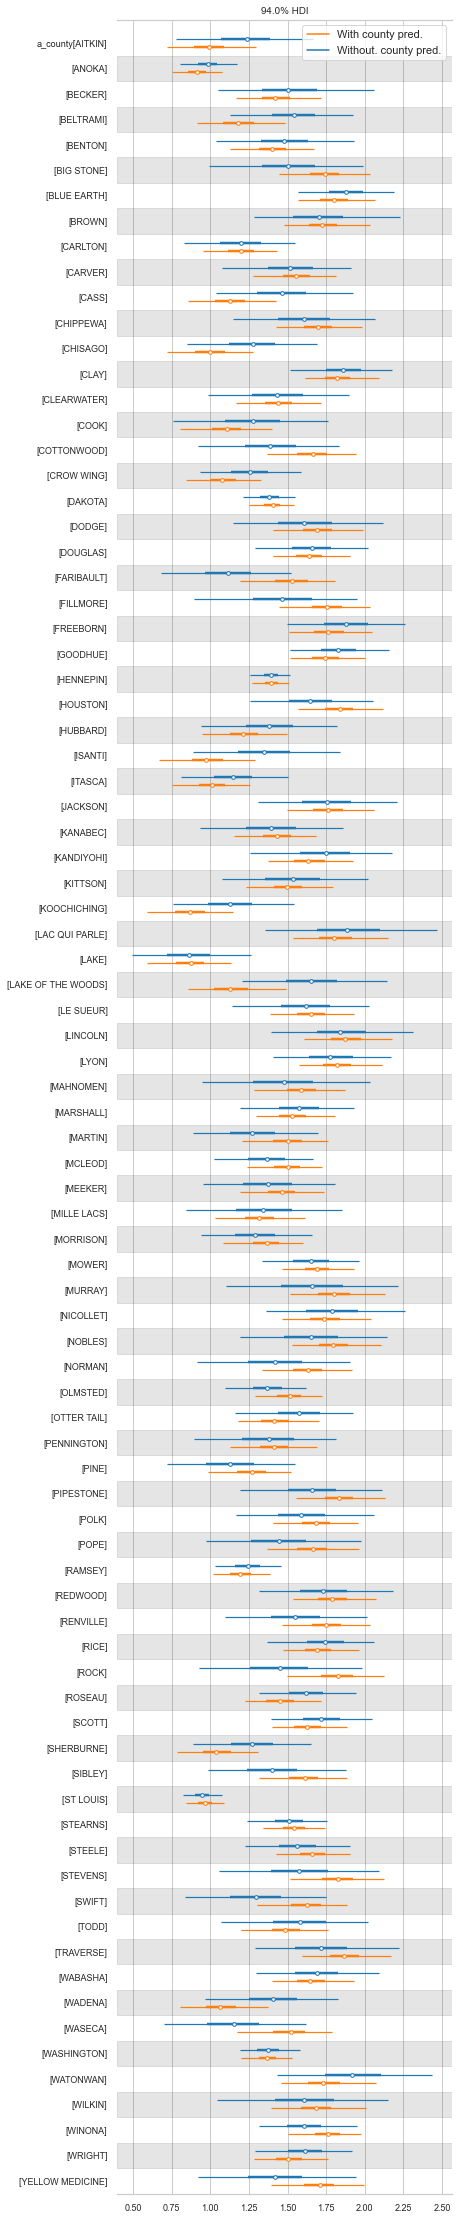

In [178]:
az.plot_forest(
    [varying_intercept_idata, hierarchical_intercept_idata],
    model_names=["Without. county pred.", "With county pred."],
    var_names=["a_county"],
    combined=True,
    figsize=(6, 40),
    textsize=9
);

We see that the compatibility intervals are **narrower** for *the model including the county-level covariate*. This is expected, as the effect of a covariate is to reduce the variation in the outcome variable – provided the covariate is of predictive value. More importantly, using this model we were able to squeeze even more information out of the data

#### Correlations among Levels

The inclusion of predictors at multiple levels can reveal correlation between individual-level variables and group residuals. For example, We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept:

$$
\alpha_j = \gamma_0+\gamma_1 u_j+\gamma_2 \bar x+\zeta_j.
$$

count    85.000000
mean      0.218123
std       0.215994
min       0.000000
25%       0.000000
50%       0.142857
75%       0.333333
max       0.750000
Name: floor, dtype: float64


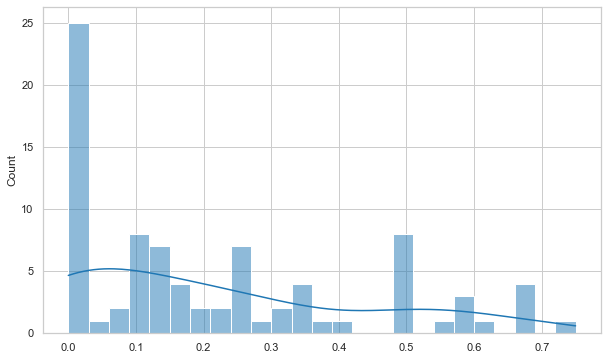

In [186]:
dt_avg_floor = srrs_mn.groupby("county")["floor"].mean().rename(county_lookup).values

# Sample Statistics
print(srrs_mn.groupby("county")["floor"].mean().describe())

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(dt_avg_floor, bins=25, kde=True)
plt.show()

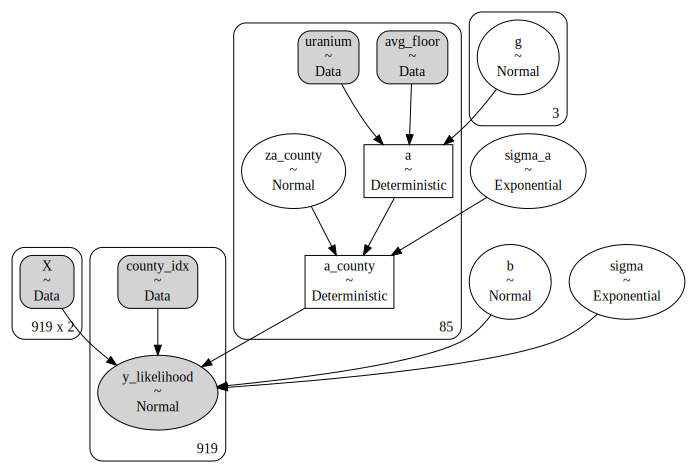

In [218]:
with pm.Model(coords=dt_coords) as contextual_effect:
    # Data
    X = pm.Data("X", dt_X, dims=("n_obs", "n_par"))
    county_idx = pm.Data("county_idx", county, dims="n_obs")
    uranium = pm.Data("uranium", uran, dims="County")
    avg_floor = pm.Data("avg_floor", dt_avg_floor, dims="County")
    
    # Hyper priors
    g = pm.Normal("g", mu=0.0, sigma=10.0, shape=3)
    sigma_a = pm.Exponential("sigma_a", 1.0)
        
    # Priors
    a = pm.Deterministic("a", g[0] + g[1] * uranium + g[2] * avg_floor, dims="County") 
    za_county = pm.Normal("za_county", mu=0.0, sigma=1.0, dims="County")
    a_county = pm.Deterministic("a_county", a + za_county * sigma_a, dims="County")
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma = pm.Exponential("sigma", 1.0)
    
    # Model
    pars = pm.math.stack((a_county[county_idx], b*pm.math.ones_like(county_idx)), axis=1)
    y = pm.math.sum(X*pars, axis=1)
    
    pm.Normal("y_likelihood", mu=y, sigma=sigma, observed=log_radon, dims="n_obs")

pm.model_to_graphviz(contextual_effect)

In [219]:
with contextual_effect:
    contextual_effect_idata = pm.sample(2000, tune=2000, target_accept=0.99, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, za_county, sigma_a, g]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 170 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [220]:
az.summary(contextual_effect_idata, var_names=["g"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g[0],1.43,0.05,1.33,1.52,0.0,0.0,3818.39,5345.15,1.0
g[1],0.70,0.09,0.53,0.86,0.0,0.0,5491.68,5744.26,1.0
g[2],0.39,0.20,0.02,0.76,0.0,0.0,4332.44,5138.34,1.0


According to the estimate of $\gamma_2$, counties with higher proportions of houses without basements tend to have higher baseline levels of radon. This seems to be opposite to our previous finding that floor was negatively associated with radon levels. But remember this finding was at the household-level: Radon tends to be higher in houses with basements. At the countylevel it seems that the less basements on average in the county, the more radon. So it's NOT that contradictory.

+ The estimate of $\gamma_2$ is quite uncertain and overlaps with zero, so it’s possible that the relationship is not that strong
+ Although $\gamma_2$ is insignificant, it probably covers something else than uranium's effect which has been already taken into account by $\gamma_1$ – it answers the question "once we know uranium level in the county, is there any value in learning about the proportion of houses without basements?"

**NOTE**: We *DONOT causally interpret* the relation between radon emissions and floor level.
+ Our causal graph is missing something: a confounding variable is lurking somewhere in the dark, affecting both basement construction and radon levels. Perhaps is it the type of soil, which might inÙuence what type of structures are built and the level of radon? Maybe adding this to our model would help with causal inference.

#### Prediction

There are two types of prediction:
+ a new individual within an existing group
+ a new individual within a new group

In [221]:
county_lookup["ST LOUIS"], county_lookup["KANABEC"]

(69, 31)

For example, for a house in St Louis, we have
$$
\bar y_i \sim N(\alpha_{69}+\beta(x_i=1),\sigma_y^2).
$$

In [222]:
prediction_coords = {"n_obs": ["ST LOUIS", "KANABEC"]}
with contextual_effect:
    pm.set_data({"county_idx": np.array([69, 31]), "X": np.array([[1, 1], [1, 1]])})
    stl_pred = pm.fast_sample_posterior_predictive(contextual_effect_idata.posterior) # It's beeter to specify "random_seed=RANDOM_SEED"
    az.from_pymc3_predictions(stl_pred, idata_orig=contextual_effect_idata, inplace=True, coords=prediction_coords)

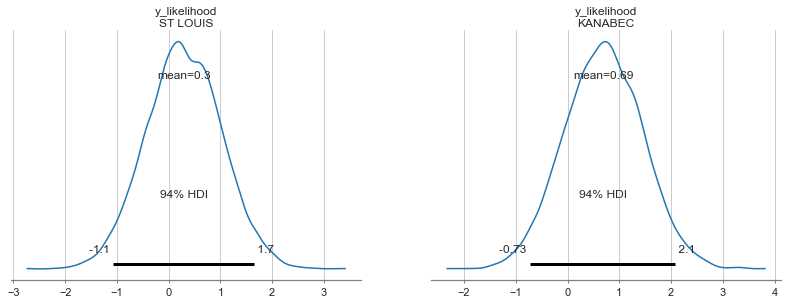

In [223]:
az.plot_posterior(contextual_effect_idata, group="predictions");